<div style="display: flex;">
    <h1 style="margin: auto; font-weight: bold; color: black; padding: 30px 30px 0px 30px;" align="center"> Projet 5 : 
Segmentez des clients d'un site e-commerce
 </h1>
</div>

<div style="display: flex; margin: auto; padding: 5px 30px 0px 30px;" > <h2 style="width: 100%; text-align: center; color: black; float: left;" align="center">Essais modélisations</h2> 
</div>

In [81]:
# Importation des librairies
import os
import io
import re
import gc
import itertools
import math
import random
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import plotly as pl
import plotly.express as px
import datetime as dt
import functools
import scipy.stats as st
import statsmodels.api as sm
import pyarrow.parquet as pq
import time as time
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import yellowbrick
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from math import prod
from sklearn import cluster
from collections import Counter
from sklearn.cluster import KMeans, AgglomerativeClustering, MiniBatchKMeans
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, mean_squared_error,  r2_score, silhouette_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.stats import shapiro, normaltest, anderson
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import train_test_split
from statsmodels.graphics.gofplots import qqplot
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils import check_random_state, shuffle
%matplotlib inline
# %load_ext pycodestyle_magic
# %pycodestyle_on


In [82]:
def plot_heatmap(corr, title, figsize=(8,4), vmin=-1, vmax=1, center=0,
                 palette = sns.color_palette("coolwarm", 20), shape='rect',
                 fmt='.2f', robust=False):
    
    fig, ax = plt.subplots(figsize=figsize)
    if shape == 'rect':
        mask=None
    elif shape == 'tri':
        mask = np.zeros_like(corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
    else:
        print('ERROR : this type of heatmap does not exist')

    palette = palette
    ax = sns.heatmap(corr, mask=mask, cmap=palette, vmin=vmin, vmax=vmax,
                     center=center, annot=True, annot_kws={"size": 10},fmt=fmt,
                     square=False, linewidths=.5, linecolor = 'white',
                     cbar_kws={"shrink": .9, 'label': None}, robust = robust,
                     xticklabels= corr.columns, yticklabels = corr.index)
    ax.tick_params(labelsize=10,top=False, bottom=True,
                labeltop=False, labelbottom=True)
    ax.collections[0].colorbar.ax.tick_params(labelsize=10)
    plt.setp(ax.get_xticklabels(), rotation=25, ha="right", rotation_mode="anchor")
    ax.set_title(title, fontweight='bold', fontsize=12)
    return mask

In [83]:
def plot_barplots(data, cols, figsize=(12,7), layout=(2,3)):

    fig = plt.figure(figsize=figsize)
    for i, c in enumerate(cols,1):
        ax = fig.add_subplot(*layout,i)
        ser = data[c].value_counts()
        n_cat = ser.shape[0]
        if n_cat>15:
            ser[0:15].plot.bar(color='green',ec='k', ax=ax)
        else:
            ser.plot.bar(color='green',ec='k',ax=ax)
        ax.set_title(c[0:17]+f' ({n_cat})', fontweight='bold')
        labels = [item.get_text() for item in ax.get_xticklabels()]
        short_labels = [s[0:7]+'.' if len(s)>7 else s for s in labels]
        ax.axes.set_xticklabels(short_labels)
        plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [84]:
df_total = pd.read_csv('df_complet_segmentation.csv')


In [85]:
df_total


review_score  payment_sequential  construction  electronics   fashion  \
0              1.00                 0.0           0.0     0.000000  0.000000   
1              0.75                 0.0           0.0     0.000000  0.224258   
2              0.50                 0.0           0.0     0.000000  0.000000   
3              0.75                 0.0           0.0     0.215413  0.000000   
4              1.00                 0.0           0.0     0.215413  0.000000   
...             ...                 ...           ...          ...       ...   
92748          1.00                 0.0           0.0     0.000000  0.355338   
92749          0.75                 0.0           0.0     0.000000  0.000000   
92750          1.00                 0.0           0.0     0.000000  0.000000   
92751          1.00                 0.0           0.0     0.000000  0.224258   
92752          1.00                 0.0           0.0     0.000000  0.224258   

           home  order_weight  leisure    others   recency  frequency  \
0      0.235411      0.603214      0.0  0.000000  0.720893        0.0   
1      0.000000      0.489044      0.0  0.000000  0.724932        0.0   
2      0.000000      0.603214      0.0  0.270373  0.960660        0.0   
3      0.000000      0.413801      0.0  0.000000  0.882237        0.0   
4      0.000000      0.718192      0.0  0.000000  0.865718        0.0   
...         ...           ...      ...       ...       ...        ...   
92748  0.000000      0.907401      0.0  0.000000  0.932692        0.0   
92749  0.000000      0.614494      0.0  0.270373  0.851315        0.0   
92750  0.000000      0.527725      0.0  0.270373  0.969219        0.0   
92751  0.000000      0.502939      0.0  0.000000  0.731434        0.0   
92752  0.000000      0.494353      0.0  0.000000  0.944816        0.0   

       monetary                                ID              rfm_label  \
0      0.395935  0000366f3b9a7992bf8c76cfdf3221e2              promising   
1      0.148965  0000b849f77a49e4a4ce2b2a4ca5be3f          new_customers   
2      0.320816  0000f46a3911fa3c0805444483337064         lost_customers   
3      0.218836  0000f6ccb0745a6a4b88665a16c9f078  hibernating_customers   
4      0.445470  0004aac84e0df4da2b147fca70cf8255       cannot_lose_them   
...         ...                               ...                    ...   
92748  0.802544  fffcf5a5ff07b0908bd4e2dbc735a684       cannot_lose_them   
92749  0.317927  fffea47cd6d3cc0a88bd621562a9d061         about_to_sleep   
92750  0.360834  ffff371b4d645b6ecea244b27531430a       cannot_lose_them   
92751  0.386932  ffff5962728ec6157033ef9805bacc48              promising   
92752  0.292817  ffffd2657e2aad2907e67c3e9daecbeb         lost_customers   

      order_purchase_timestamp  
0                   2018-05-10  
1                   2018-05-07  
2                   2017-03-10  
3                   2017-10-12  
4                   2017-11-14  
...                        ...  
92748               2017-06-08  
92749               2017-12-10  
92750               2017-02-07  
92751               2018-05-02  
92752               2017-05-02  

[92753 rows x 15 columns]

In [86]:
df = df_total.sample(n=None, frac=0.2, replace=False, weights=None,
                     random_state=0, axis='index', ignore_index=False)


In [87]:
df.columns


Index(['review_score', 'payment_sequential', 'construction', 'electronics',
       'fashion', 'home', 'order_weight', 'leisure', 'others', 'recency',
       'frequency', 'monetary', 'ID', 'rfm_label', 'order_purchase_timestamp'],
      dtype='object')

In [88]:
customers = ['ID']
features = ['order_weight', 'review_score', 'recency', 'frequency', 'monetary', 'payment_sequential',
            'construction', 'electronics', 'fashion', 'home', 'leisure', 'others']
cat = ['rfm_label']
rfm = ['recency', 'frequency', 'monetary']


<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2. Clustering kmeans sur 3 variables RFM </h3>
</div>

<div style="background-color: black;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">a. Dataset = rfm (3variables) </h4>
</div>

In [89]:
df_rfm = df[rfm]


In [90]:
df_rfm.describe()


recency     frequency      monetary
count  18551.000000  18551.000000  18551.000000
mean       0.787878      0.006108      0.358875
std        0.144446      0.036125      0.123141
min        0.000000      0.000000      0.000000
25%        0.722251      0.000000      0.273098
50%        0.822644      0.000000      0.353020
75%        0.894976      0.000000      0.432797
max        1.000000      0.666667      0.921294

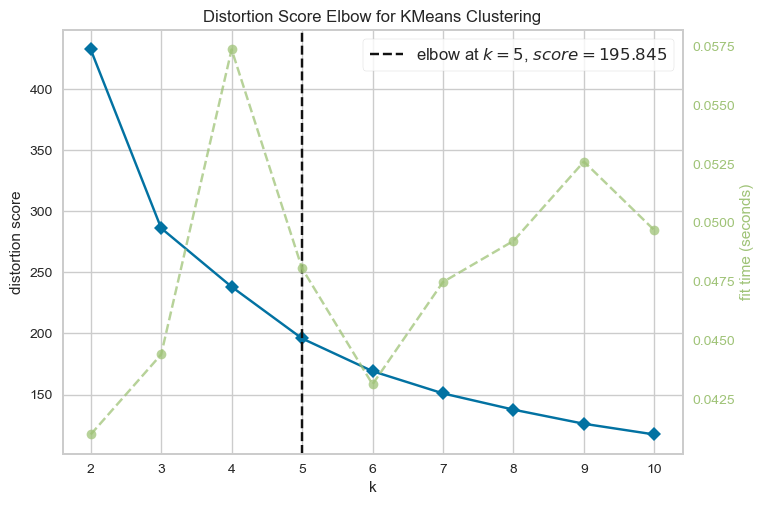

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [91]:
# Instanciation du modèle de regroupement et du visualisateur
model = KMeans(n_init=1, random_state=1)
visualizer = KElbowVisualizer(model, k=(2, 11))
visualizer.fit(df_rfm)
visualizer.poof()


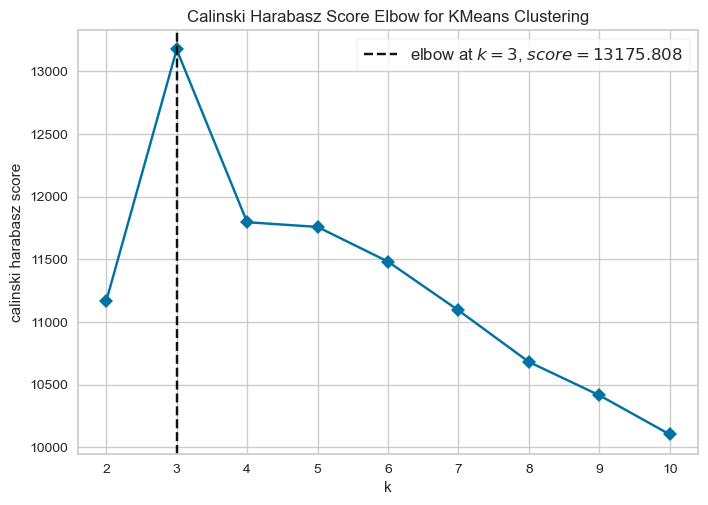

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [92]:
# Instanciation du modèle de regroupement et du visualisateur
model = KMeans(n_init=1, random_state=1)
visualizer = KElbowVisualizer(
    model, k=(2, 11), metric='calinski_harabasz', timings=False)
visualizer.fit(df_rfm)
visualizer.poof()


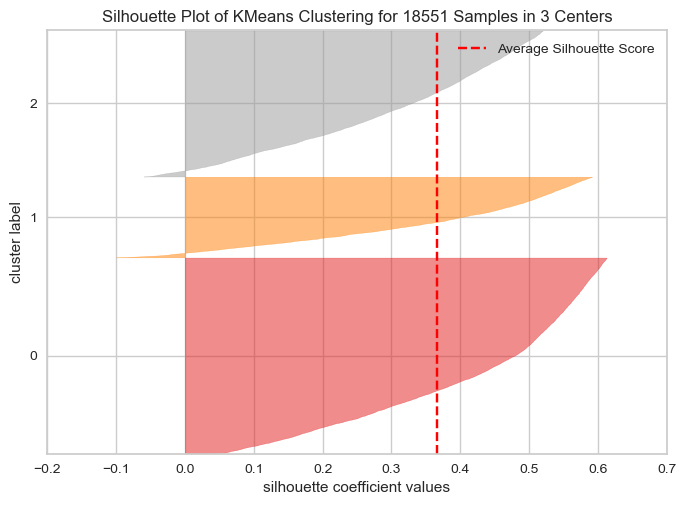

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 18551 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [93]:
# Instanciation du modèle de regroupement et du visualisateur
model = KMeans(n_clusters=3, n_init=1, random_state=1)
visualizer = SilhouetteVisualizer(model)
visualizer.fit(df_rfm)
visualizer.poof()


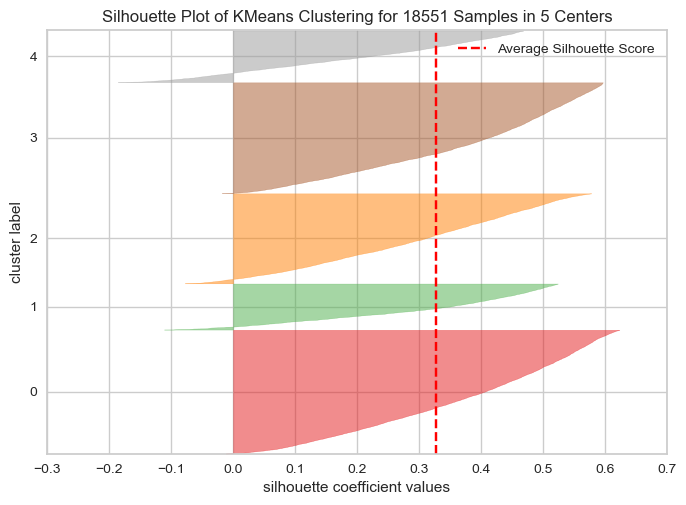

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 18551 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [94]:
# Instanciation du modèle de regroupement et du visualisateur
model = KMeans(n_clusters=5, n_init=1, random_state=1)
visualizer = SilhouetteVisualizer(model)
visualizer.fit(df_rfm)
visualizer.poof()


In [95]:
from sklearn.model_selection import GridSearchCV, _validation
# Definir les hyperparamètres candidats
base_estimator = KMeans(n_clusters=5, n_init=1, algorithm="lloyd")
param_grid = [{'init': ["k-means++", "random"],
               'max_iter': [100, 200, 300, 400, 500]}]
# Recherche les meilleurs
grid = GridSearchCV(estimator=base_estimator,
                    param_grid=param_grid, cv=None, scoring=None)
grid.fit(df_rfm, None)
# Afficher les resultats
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)


-39.2310136742082
KMeans(init='random', max_iter=100, n_clusters=5, n_init=1)
{'init': 'random', 'max_iter': 100}


In [96]:
kmeans = cluster.KMeans(n_clusters=5, n_init=1,
                        init='k-means++', max_iter=400, random_state=1)
kmeans.fit(df_rfm)


KMeans(max_iter=400, n_clusters=5, n_init=1, random_state=1)

In [97]:
# Ici nous évaluons la stabilité à l'initialisation de notre modèle:
from sklearn.metrics import adjusted_rand_score
ari_score_init_rfm = []
for k in range(0, 10):
    kmeans_k_init = KMeans(n_clusters=5, n_init=1)
    kmeans_k_init.fit(df_rfm)
    ari_score_init_rfm.append(adjusted_rand_score(
        kmeans.labels_, kmeans_k_init.labels_))


In [98]:
np.mean(ari_score_init_rfm)
# Bonne stabilité à l'initialisation


0.9719714888483472

c:\Users\camil\anaconda3\envs\camille\lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names

c:\Users\camil\anaconda3\envs\camille\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



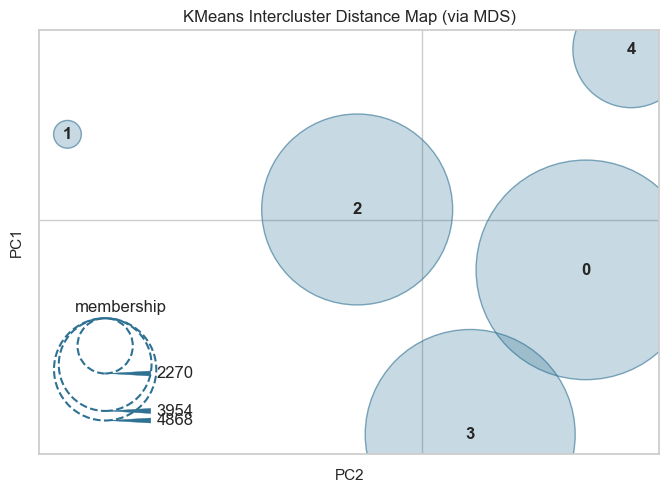

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [99]:
from yellowbrick.cluster import InterclusterDistance
# Distance inter-clusters Map avec le meilleur k
distance_visualizer = InterclusterDistance(kmeans)
distance_visualizer.fit(df_rfm)
distance_visualizer.show()


In [100]:
labels = kmeans.labels_
dd = {i: j for i, j in enumerate(list("abcde"))}
labelsabc = [dd[i] for i in kmeans.labels_]


In [101]:
df_rfm["cluster_kmeans_rfm"] = labelsabc


C:\Users\camil\AppData\Local\Temp\ipykernel_19836\543590566.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [102]:
import plotly.express as px
import plotly.io as pio
fig = px.scatter_3d(df_rfm, x='recency', y='frequency', z='monetary',
                    color='cluster_kmeans_rfm')
pio.show(fig)


In [103]:
khi2 = pd.DataFrame()
khi2['rfm_label'] = df[['rfm_label']]
khi2["cluster_kmeans_rfm"] = labelsabc


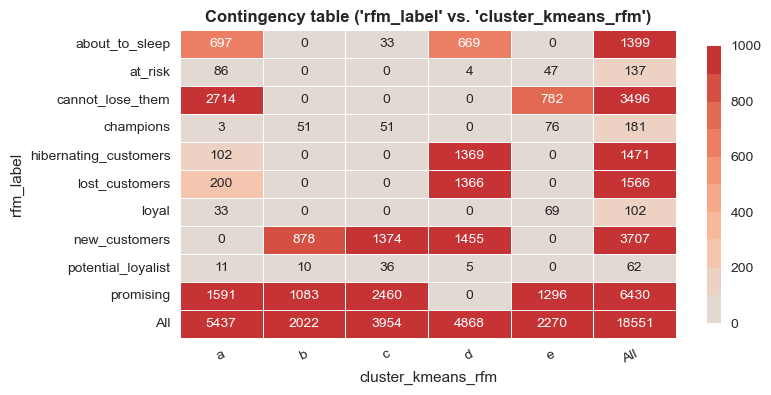

In [104]:
data_crosstab = pd.crosstab(khi2['rfm_label'],
                            khi2['cluster_kmeans_rfm'],
                            margins=True)
plot_heatmap(data_crosstab, "Contingency table ('rfm_label' vs. 'cluster_kmeans_rfm')",
             vmin=0, vmax=1000, palette=sns.color_palette("coolwarm", 20),
             figsize=(8, 4), shape='rect', fmt='.0f')


In [105]:
# Chi-Squared Test
from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency(data_crosstab)
print('---'+"Chi-squared")
print('stat=%.3f, p=%.8f' % (stat, p))
print('Probably independent') if p > 0.05 else print('Probably dependent')


---Chi-squared
stat=19338.340, p=0.00000000
Probably dependent


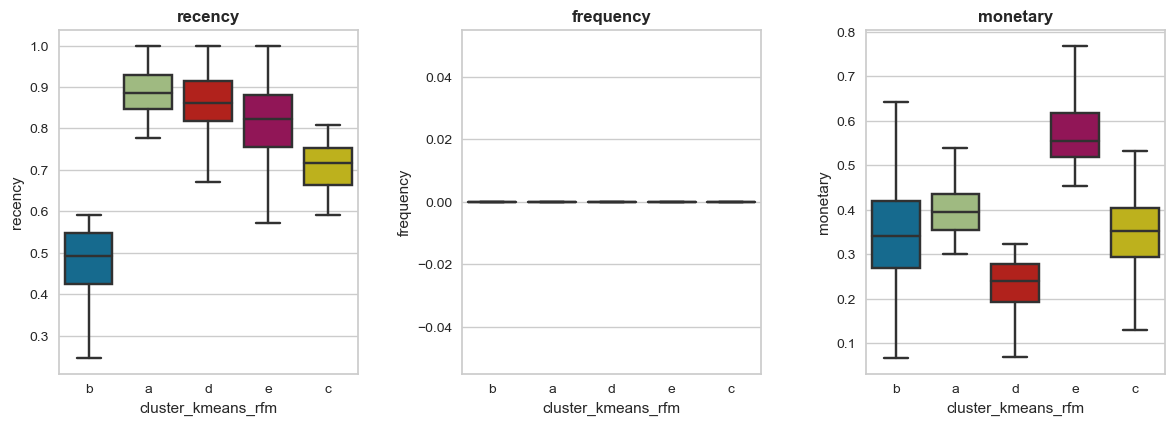

In [106]:
fig = plt.figure(figsize=(15, 60))
for i, c in enumerate(rfm, 1):
    ax = fig.add_subplot(2, 4, i)
    sns.boxplot(data=df_rfm, x="cluster_kmeans_rfm",
                y=df_rfm[c], showfliers=False)
    ax.set_title(c)
    ax.title.set_fontweight('bold')

plt.tight_layout(w_pad=2, h_pad=0.65)
plt.gcf().set_size_inches(16, 7)
plt.show()


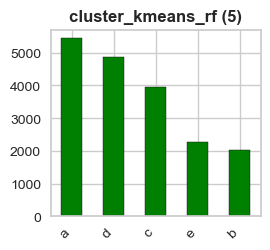

In [107]:
cluster_kmeans_rfm = ['cluster_kmeans_rfm']
plot_barplots(data=khi2, cols=cluster_kmeans_rfm,
              figsize=(12, 7), layout=(3, 5))
plt.show()


In [108]:
df_rfm['cluster_kmeans_rfm'].value_counts()


a    5437
d    4868
c    3954
e    2270
b    2022
Name: cluster_kmeans_rfm, dtype: int64

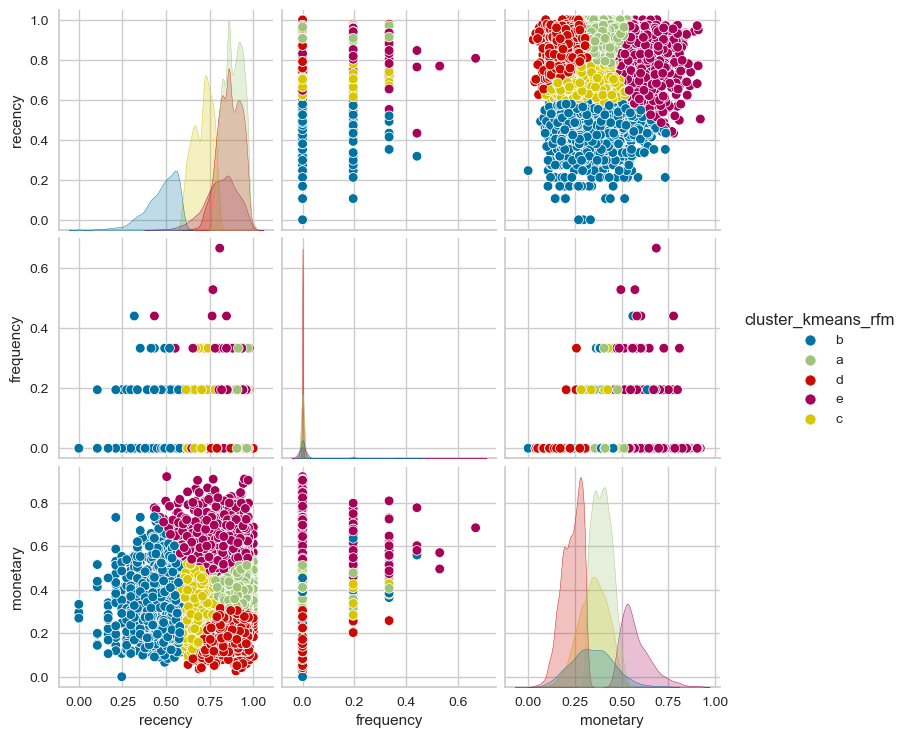

In [109]:
sns.pairplot(df_rfm, hue="cluster_kmeans_rfm")


In [110]:
df_rfm = df_rfm.drop(columns='cluster_kmeans_rfm')
df_rfm


recency  frequency  monetary
21740  0.317698        0.0  0.330922
62219  0.524645        0.0  0.363769
69801  0.887369        0.0  0.428384
30486  0.854192        0.0  0.253400
40545  0.871934        0.0  0.420266
...         ...        ...       ...
13540  0.870403        0.0  0.304924
25429  0.906330        0.0  0.411478
40324  0.524645        0.0  0.410407
16777  0.792530        0.0  0.411411
5097   0.790813        0.0  0.276590

[18551 rows x 3 columns]

<div style="background-color: black;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">b. Dataset = entier </h4>
</div>

In [111]:
df_total = df[features]


In [112]:
df_total.shape


(18551, 12)

In [113]:
df_rfm.shape


(18551, 3)

In [114]:
# Générer le graphique plus bas, qui permet de regarder si les clusters rfm étudié plus haut, sont dépendants des catégories (presentes dans df_total)
df_total['cluster_kmeans_rfm'] = khi2['cluster_kmeans_rfm']
feat = ['order_weight', 'review_score',
        'recency', 'monetary', 'fashion', 'home']


C:\Users\camil\AppData\Local\Temp\ipykernel_19836\1452147828.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



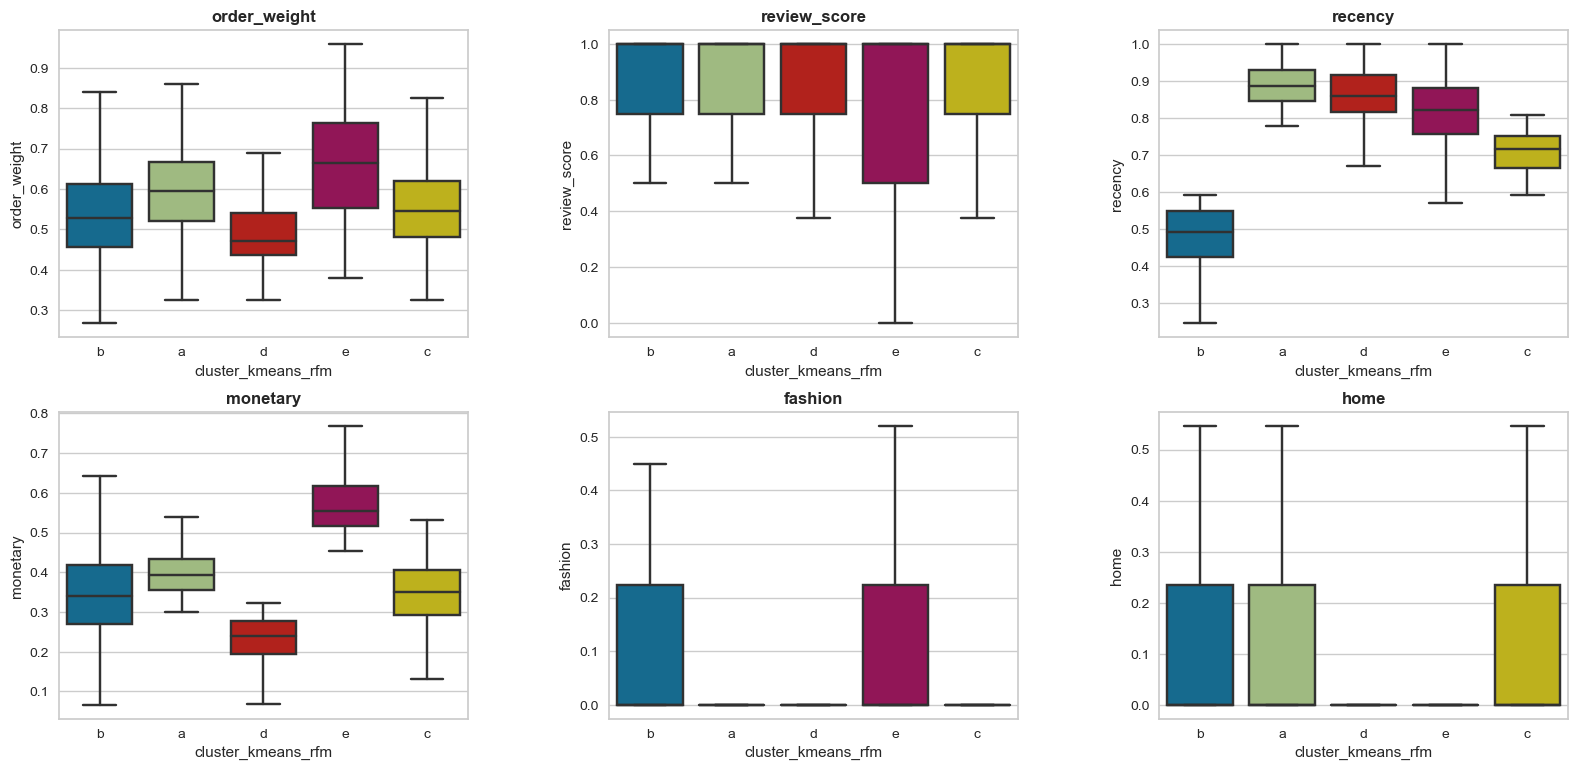

In [115]:
fig = plt.figure(figsize=(15, 60))
for i, c in enumerate(feat, 1):
    ax = fig.add_subplot(2, 3, i)
    sns.boxplot(data=df_total, x="cluster_kmeans_rfm",
                y=df_total[c], showfliers=False)
    ax.set_title(c)
    ax.title.set_fontweight('bold')

plt.tight_layout(w_pad=5, h_pad=35)
plt.gcf().set_size_inches(16, 7)
plt.show()


In [116]:
df_total = df_total.drop(columns='cluster_kmeans_rfm')


In [117]:
df_total.describe()


order_weight  review_score       recency     frequency      monetary  \
count  18551.000000  18551.000000  18551.000000  18551.000000  18551.000000   
mean       0.561398      0.787908      0.787878      0.006108      0.358875   
std        0.113023      0.320342      0.144446      0.036125      0.123141   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.470695      0.750000      0.722251      0.000000      0.273098   
50%        0.551417      1.000000      0.822644      0.000000      0.353020   
75%        0.634784      1.000000      0.894976      0.000000      0.432797   
max        0.959025      1.000000      1.000000      0.666667      0.921294   

       payment_sequential  construction   electronics       fashion  \
count        18551.000000  18551.000000  18551.000000  18551.000000   
mean             0.007874      0.016252      0.034978      0.057534   
std              0.038236      0.068180      0.084409      0.103626   
min              0.000000      0.000000      0.000000      0.000000   
25%              0.000000      0.000000      0.000000      0.000000   
50%              0.000000      0.000000      0.000000      0.000000   
75%              0.000000      0.000000      0.000000      0.000000   
max              0.881760      0.976761      0.745146      0.672773   

               home       leisure        others  
count  18551.000000  18551.000000  18551.000000  
mean       0.068591      0.045978      0.044404  
std        0.122533      0.111980      0.105999  
min        0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.000000  
50%        0.000000      0.000000      0.000000  
75%        0.235411      0.000000      0.000000  
max        0.843501      0.811482      0.811120

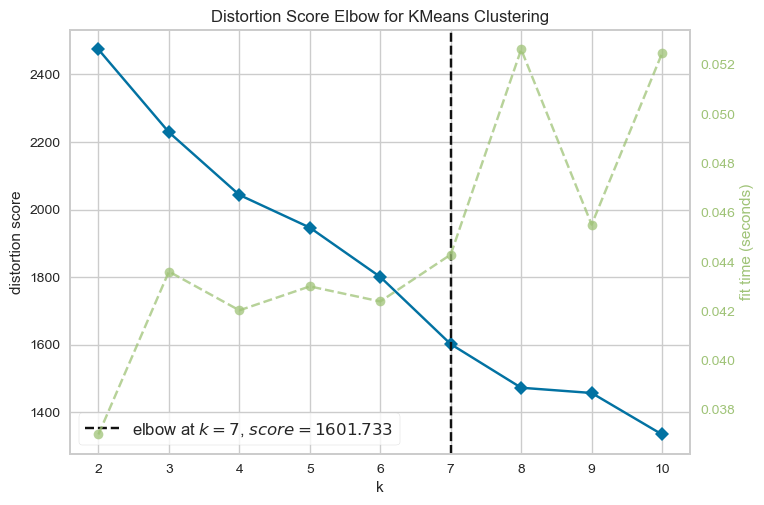

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [118]:
model = KMeans(n_init=1, random_state=1)
visualizer = KElbowVisualizer(model, k=(2, 11))
visualizer.fit(df_total)
visualizer.poof()


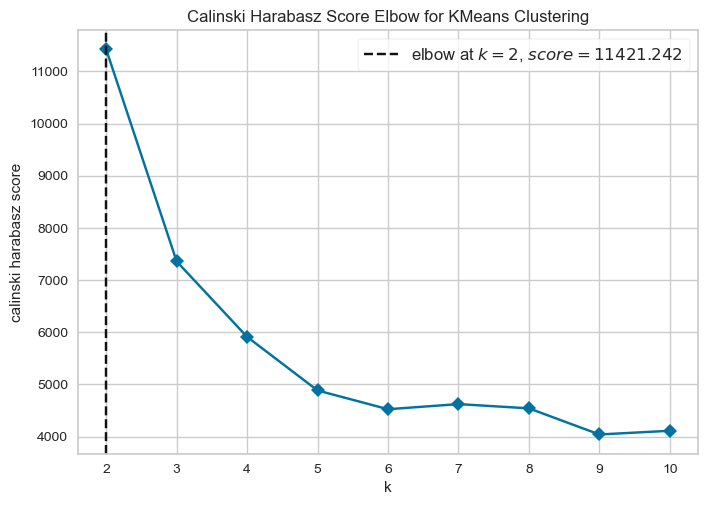

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [119]:
model = KMeans(n_init=1, random_state=1)
visualizer = KElbowVisualizer(
    model, k=(2, 11), metric='calinski_harabasz', timings=False)
visualizer.fit(df_total)
visualizer.poof()


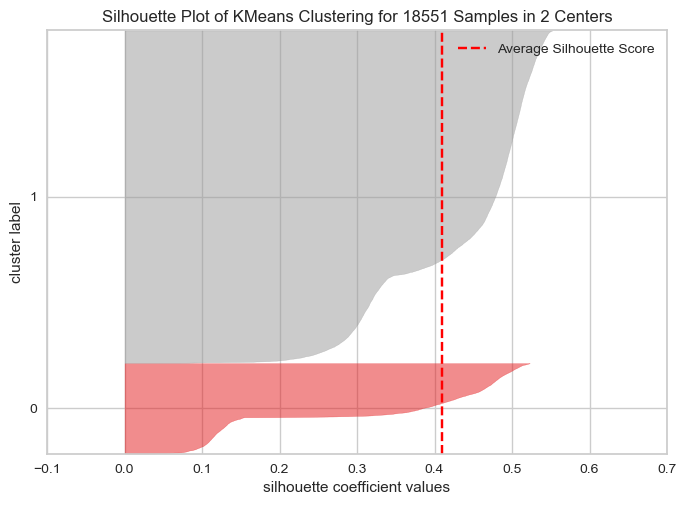

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 18551 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [120]:
model = KMeans(n_clusters=2, n_init=1, random_state=1)
visualizer = SilhouetteVisualizer(model)
visualizer.fit(df_total)
visualizer.poof()


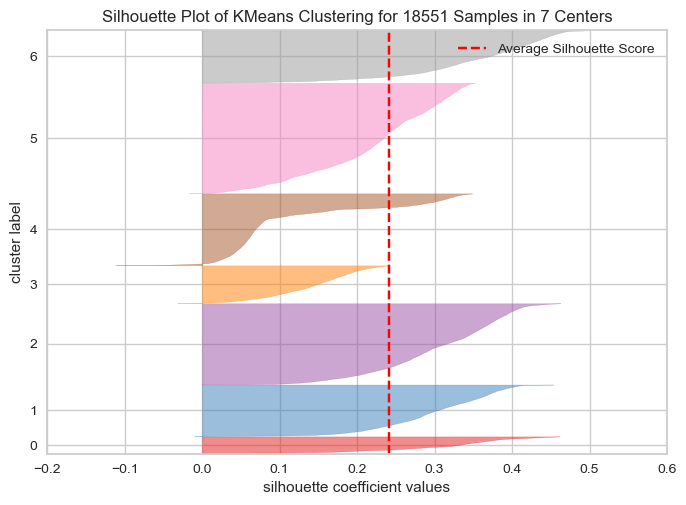

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 18551 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [121]:
model = KMeans(n_clusters=7, n_init=1, random_state=1)
visualizer = SilhouetteVisualizer(model)
visualizer.fit(df_total)
visualizer.poof()


In [122]:
from sklearn.model_selection import GridSearchCV, _validation
# Hyperparamètres optimaux à identifier
base_estimator = KMeans(n_clusters=2, n_init=1, algorithm="lloyd")
param_grid = [{'init': ["k-means++", "random"],
               'max_iter': [100, 200, 300, 400, 500]}]
grid = GridSearchCV(estimator=base_estimator,
                    param_grid=param_grid, cv=None, scoring=None)
grid.fit(df_total, None)
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)


-494.9253293781529
KMeans(max_iter=100, n_clusters=2, n_init=1)
{'init': 'k-means++', 'max_iter': 100}


In [123]:
kmeans = cluster.KMeans(n_clusters=7, init='k-means++',
                        max_iter=100, n_init=1, random_state=1)
kmeans.fit(df_total)


KMeans(max_iter=100, n_clusters=7, n_init=1, random_state=1)

In [124]:
labels = kmeans.labels_
dd = {i: j for i, j in enumerate(list("abcdefg"))}
labels_abcde = [dd[i] for i in kmeans.labels_]
df_total["cluster_kmeans_total"] = labels_abcde


In [125]:
khi2["cluster_kmeans_total"] = labels_abcde
# khi2["products_category"] = df["products_category"]


In [126]:
data_crosstab = pd.crosstab(khi2['rfm_label'],
                            khi2['cluster_kmeans_total'],
                            margins=True)
plot_heatmap(data_crosstab, "Contingency table ('rfm_label' vs. 'cluster_kmeans_total')",
             vmin=0, vmax=1000, palette=sns.color_palette("coolwarm", 20),
             figsize=(8, 4), shape='rect', fmt='.0f')


In [127]:
# On ne dégage pas vraiment de profils spécifiques intéressants ici.


In [128]:
# Chi-Squared Test
from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency(data_crosstab)
print('---'+"Chi-squared")
print('stat=%.3f, p=%.8f' % (stat, p))
print('Probably independent') if p > 0.05 else print('Probably dependent')


---Chi-squared
stat=282.594, p=0.00000000
Probably dependent


In [129]:
fig = plt.figure(figsize=(15, 60))
for i, c in enumerate(features, 1):
    ax = fig.add_subplot(4, 4, i)
    sns.boxplot(data=df_total, x="cluster_kmeans_total",
                y=df_total[c], showfliers=False)
    ax.set_title(c)
    ax.title.set_fontweight('bold')
plt.tight_layout(w_pad=3, h_pad=30)
plt.gcf().set_size_inches(16, 7)
plt.show()


In [130]:
cluster_kmeans_total = ['cluster_kmeans_total']
plot_barplots(data=khi2, cols=cluster_kmeans_total,
              figsize=(12, 7), layout=(3, 5))
plt.show()


In [131]:
df_total['cluster_kmeans_total'].value_counts()


f    4855
c    3565
e    3157
g    2292
b    2271
d    1659
a     752
Name: cluster_kmeans_total, dtype: int64

<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3. Aglomerative Clustering </h3>
</div>

<div style="background-color: black;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">a. Dataset = rfm (3variables) </h4>
</div>

In [132]:
rfm= ['recency', 'frequency', 'monetary']

In [133]:
df_rfm = df_rfm[rfm]


In [134]:
df_rfm


recency  frequency  monetary
21740  0.317698        0.0  0.330922
62219  0.524645        0.0  0.363769
69801  0.887369        0.0  0.428384
30486  0.854192        0.0  0.253400
40545  0.871934        0.0  0.420266
...         ...        ...       ...
13540  0.870403        0.0  0.304924
25429  0.906330        0.0  0.411478
40324  0.524645        0.0  0.410407
16777  0.792530        0.0  0.411411
5097   0.790813        0.0  0.276590

[18551 rows x 3 columns]

<div style="background-color: black;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">a.1 Ward method 

In [135]:
model = AgglomerativeClustering(metric="euclidean", linkage="ward")
visualizer = KElbowVisualizer(model, k=(2, 11))
visualizer.fit(df_rfm)
visualizer.poof()


<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [136]:
model = AgglomerativeClustering(metric="euclidean", linkage="ward")
visualizer = KElbowVisualizer(
    model, k=(2, 11), metric='calinski_harabasz', timings=False)
visualizer.fit(df_rfm)
visualizer.poof()


<Axes: title={'center': 'Calinski Harabasz Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [137]:
model = AgglomerativeClustering(
    n_clusters=5, metric="euclidean", linkage="ward")
model.fit(df_rfm)


AgglomerativeClustering(metric='euclidean', n_clusters=5)

In [138]:
labels = model.labels_
dd = {i: j for i, j in enumerate(list("abcde"))}
labelsabc = [dd[i] for i in model.labels_]
df_rfm["cluster_model_rfm"] = labelsabc


In [139]:
import plotly.express as px
import plotly.io as pio
fig = px.scatter_3d(df_rfm, x='recency', y='frequency', z='monetary',
                    color='cluster_model_rfm')
pio.show(fig)


In [140]:
khi2 = pd.DataFrame()
khi2['rfm_label'] = df[['rfm_label']]
khi2["cluster_model_rfm"] = labelsabc


In [141]:
data_crosstab = pd.crosstab(khi2['rfm_label'],
                            khi2['cluster_model_rfm'],
                            margins=True)
plot_heatmap(data_crosstab, "Contingency table ('rfm_label' vs. 'cluster_model_rfm')",
             vmin=0, vmax=1000, palette=sns.color_palette("coolwarm", 20),
             figsize=(8, 4), shape='rect', fmt='.0f')


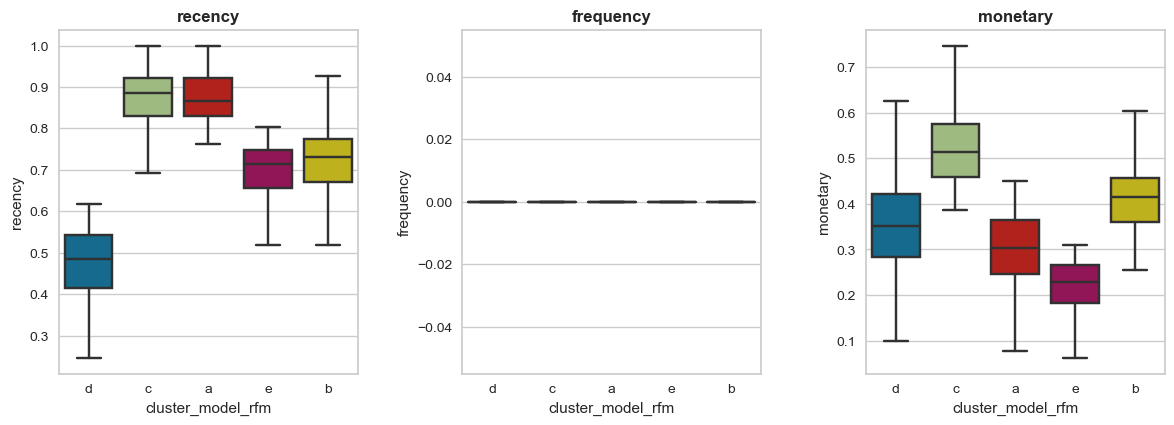

In [142]:
fig = plt.figure(figsize=(15, 60))
for i, c in enumerate(rfm, 1):
    ax = fig.add_subplot(2, 4, i)
    sns.boxplot(data=df_rfm, x="cluster_model_rfm",
                y=df_rfm[c], showfliers=False)
    ax.set_title(c)
    ax.title.set_fontweight('bold')
plt.tight_layout(w_pad=2, h_pad=0.65)
plt.gcf().set_size_inches(16, 7)
plt.show()


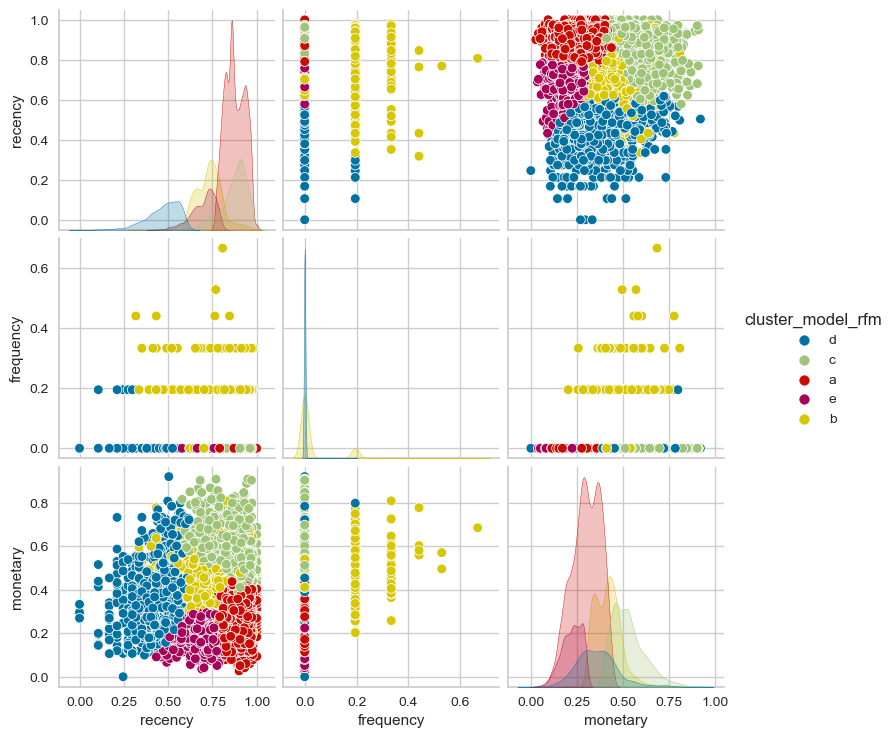

In [143]:
sns.pairplot(df_rfm, hue="cluster_model_rfm")


<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">4. Clustering DBSCAN </h3>
</div>

<div style="background-color: black;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">a. Dataset =rfm (3variables) </h4>
</div>

In [153]:
df_rfm


recency  frequency  monetary  cluster_dbscan_rfm cluster_model_rfm
21740  0.317698        0.0  0.330922                   0                 a
62219  0.524645        0.0  0.363769                   0                 a
69801  0.887369        0.0  0.428384                   0                 a
30486  0.854192        0.0  0.253400                   0                 a
40545  0.871934        0.0  0.420266                   0                 a
...         ...        ...       ...                 ...               ...
13540  0.870403        0.0  0.304924                   0                 a
25429  0.906330        0.0  0.411478                   0                 a
40324  0.524645        0.0  0.410407                   0                 a
16777  0.792530        0.0  0.411411                   0                 a
5097   0.790813        0.0  0.276590                   0                 a

[18551 rows x 5 columns]

In [176]:
df_rfm = df_rfm[rfm]


In [177]:
from sklearn import metrics
from sklearn.cluster import DBSCAN
for e in np.arange(0.1, 1, 0.1):
    dbscan = DBSCAN(eps=e, min_samples=200)
    model = dbscan.fit(df_rfm)
    labels = dbscan.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)


Estimated number of clusters: 1
Estimated number of noise points: 661
Estimated number of clusters: 1
Estimated number of noise points: 11
Estimated number of clusters: 1
Estimated number of noise points: 0
Estimated number of clusters: 1
Estimated number of noise points: 0
Estimated number of clusters: 1
Estimated number of noise points: 0
Estimated number of clusters: 1
Estimated number of noise points: 0
Estimated number of clusters: 1
Estimated number of noise points: 0
Estimated number of clusters: 1
Estimated number of noise points: 0
Estimated number of clusters: 1
Estimated number of noise points: 0


In [178]:
from sklearn import metrics
from sklearn.cluster import DBSCAN
for e in np.arange(1, 100, 10):
    dbscan = DBSCAN(eps=0.5, min_samples=e)
    model = dbscan.fit(df_rfm)
    labels = dbscan.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)


Estimated number of clusters: 1
Estimated number of noise points: 0
Estimated number of clusters: 1
Estimated number of noise points: 0
Estimated number of clusters: 1
Estimated number of noise points: 0
Estimated number of clusters: 1
Estimated number of noise points: 0
Estimated number of clusters: 1
Estimated number of noise points: 0
Estimated number of clusters: 1
Estimated number of noise points: 0
Estimated number of clusters: 1
Estimated number of noise points: 0
Estimated number of clusters: 1
Estimated number of noise points: 0
Estimated number of clusters: 1
Estimated number of noise points: 0
Estimated number of clusters: 1
Estimated number of noise points: 0


In [179]:
# Aucun des hyperparamètres testés ne permet de générer des clusters satisfaisants avec cette agorithme.


In [180]:
dbscan = DBSCAN(eps=0.5, min_samples=100)
model = dbscan.fit(df_rfm)
labels = model.labels_
khi2["cluster_dbscan_rfm"] = labels
df_rfm["cluster_dbscan_rfm"] = labels
dd = {i: j for i, j in enumerate(list("abcde"))}
labelsabc = [dd[i] for i in model.labels_]
df_rfm["cluster_model_rfm"] = labelsabc


In [181]:
import plotly.express as px
import plotly.io as pio
fig = px.scatter_3d(df_rfm, x='recency', y='frequency', z='monetary',
                    color='cluster_model_rfm')
pio.show(fig)


In [182]:
khi2 = pd.DataFrame()
khi2['rfm_label'] = df[['rfm_label']]
khi2["cluster_model_rfm"] = labelsabc


In [183]:
data_crosstab = pd.crosstab(khi2['rfm_label'],
                            khi2['cluster_model_rfm'],
                            margins=True)
plot_heatmap(data_crosstab, "Contingency table ('rfm_label' vs. 'cluster_model_rfm')",
             vmin=0, vmax=1000, palette=sns.color_palette("coolwarm", 20),
             figsize=(8, 4), shape='rect', fmt='.0f')
